# COMP90051 Project 2

In [2]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implementing ε-Greedy and UCB

In [4]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [5]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    def __init__(self, narms, epsilon, Q0=np.inf):
        ## Check that narms is positive value
        assert narms>0
        ## Check epsilon that should be in range (0,1]
        assert (epsilon>0 and epsilon<=1 )
        self.narms=int(narms)
        self.epsilon=float(epsilon)
        self.Q0=Q0
        
        ## Initialize default value for each arm both estimate 
        ## and count of how many the arm has been selected
        self.count = [0 for i in range(self.narms) ]
        self.estimate = [ self.Q0 for i in range(self.narms)]
        
    def play(self, tround, context=None):
        ## Check that tround need to be positive integer
        assert tround>0
        self.tround=tround
        ## Random by using binomail of probability of self.epsilon
        ## Output is either 1 or 0
        ## If 1, then it's explore else exploit
        prob=np.random.binomial(1,self.epsilon)
        if(prob):
            ## Randomly select arm
            return np.random.randint(self.narms)
        else:
            ## Tie-breaking at completely uniformly-at-random
            index_list = [i for i,j in enumerate(self.estimate) if j==max(self.estimate)]
            return np.random.choice(index_list)+1
        
    def update(self, arm, reward, context=None):
        ## Check that arm value is no larger than narms
        assert arm <= self.narms
        self.arm=arm
        self.reward=float(reward)
        ## Increment count of arm that is selected
        self.count[self.arm-1] += 1
        
        ## if self.estimate of that arm is infinity
        ## Change it to 0 because if not, infinity plus any value is infinity
        if self.estimate[self.arm-1] == np.inf:
            self.estimate[self.arm-1] = 0 
        self.estimate[self.arm-1] += (self.reward - self.estimate[self.arm-1]) / float(self.count[self.arm-1])
    

In [6]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        ## Check that narms and rho is positive value
        assert narms>0
        assert rho>0
        self.narms=int(narms)
        self.rho=float(rho)
        self.Q0=Q0
        ## Initialize default value for each arm both estimate 
        ## and count of how many the arm has been selected
        self.count = [0 for i in range(self.narms) ]
        self.estimate = [ self.Q0 for i in range(self.narms)]
    
    def play(self, tround, context=None):
        ## Check that tround need to be positive integer
        assert tround>=0
        self.tround=tround
        #Check that is sum of count is greater than zero
        #If true then add estimate with the formula to q
        #else use inital value of Q0
        if np.sum(self.count)>0:
            q = self.estimate+np.sqrt(self.rho * np.log(self.tround) / (self.count))
        else:
            q = self.estimate
        ## Tie-breaking at completely uniformly-at-random
        result = [i for i,j in enumerate(q) if j==max(q)]
        return np.random.choice(result)+1
        
    def update(self, arm, reward, context=None):
        ## Check that arm value is no larger than narms
        assert arm <= self.narms
        self.arm=arm
        self.reward=float(reward)
        
        ## Increment count of arm that is selected
        self.count[self.arm-1] += 1
        ## if self.estimate of that arm is infinity
        ## Change it to 0 because if not, infinity plus any value is infinity
        if self.estimate[self.arm-1] == np.inf:
            self.estimate[self.arm-1] = 0 
        #Update estimate value
        self.estimate[self.arm-1] += (self.reward - self.estimate[self.arm-1]) / float(self.count[self.arm-1])
    
    

## 2. The Basic Thompson Bandit

In [7]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        ## Check that narms and rho is positive value
        assert narms>0
        self.narms=int(narms)
        
        ##Initialize alpha and beta for each arm
        self.alpha= [alpha0 for i in range(self.narms)]
        self.beta= [beta0 for i in range(self.narms)]
    
    def play(self, tround, context=None):
        ## Check that tround need to be positive integer
        assert tround>0
        self.tround=tround
        ## Sample from beta distribution by using alpha and beta
        ## value for each arm
        beta_sample=[np.random.beta(self.alpha[i],self.beta[i]) for i in range(self.narms)]
        ## Tie-breaking at completely uniformly-at-random
        result = [i for i,j in enumerate(beta_sample) if j==max(beta_sample)]
        return np.random.choice(result)+1

    def update(self, arm, reward, context=None):
        ## Check that arm value is no larger than narms
        assert arm <= self.narms
        self.arm=arm
        self.reward=float(reward)
        
        ## Observe reward if reward equal 1 then update
        ## alpha value of that arm by one else update beta value by 1
        if(self.reward == 1.0):
            self.alpha[self.arm-1]+=1.0
        else:
            self.beta[self.arm-1]+=1.0

## 3. Off-Policy Evaluation

In [8]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    
    #Initailize list for history and reward
    history=list()
    reward_a=list()
    #Counter variable for when it equal to nrounds then break the loop
    j=0
    
    #Iterate by using range of context
    for i in range(contexts.shape[0]):
        
        if j==nrounds:
            break
        #Play the mab if it's equal to arms then update the mab
        if(mab.play(len(history)+1,contexts[i,:]) == arms[i]):
            mab.update(arms[i],rewards[i],contexts[i,:])
            #Append the history,arm,reward and context to the history list
            history.append([history,arms[i],rewards[i],contexts[i,:]])
            #Append the rewards to reward list
            reward_a.append(rewards[i])
            j+=1
    return reward_a

In [9]:
#Read the file
dataset = np.loadtxt("dataset.txt")
arms = dataset[:,0]
rewards = dataset[:,1]
contexts = dataset[:,2:]
#Arms need to be integer
arms=arms.astype("int")

In [10]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.27


In [11]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


UCB average reward 0.17


In [12]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.21375


## 4. Contextual Bandits - LinUCB

In [13]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        # Check that narms,ndims and alpha(it can be zero) is positive value
        assert narms > 0
        assert ndims > 0
        assert alpha >=0
        self.narms=int(narms)
        self.ndims=int(ndims)
        self.alpha=float(alpha)
        #Initialize A,b,theta_hat and pt_a value list
        self.A=[0 for i in range(self.narms)]
        self.b=[0 for i in range(self.narms)]
        self.theta_hat=[0 for i in range(self.narms)]
        self.pt_a=[0 for i in range(self.narms)]
        # Initialize in each of A,b list to be identity matrix of ndims dimension
        # and vector of zero of ndims dimenstion respectively 
        for i in range(self.narms):
            self.A[i]=np.identity(self.ndims)
            self.b[i]=np.zeros((self.ndims,1))
            
    def play(self, tround, context):
        #Check that tround is positive integer
        assert tround>0
        self.tround=tround
        #Reshape the context into desired dimension so that we can do matrix multiplication
        x=context.reshape(self.narms,self.ndims)
        for i in range(self.narms):
            #Reshape the x of each arm into self.narmsx1 dimenstion
            xt=x[i].reshape(self.narms,1)
            self.theta_hat[i] = inv(self.A[i]) @ self.b[i]
            self.pt_a[i]=self.theta_hat[i].T @ xt + self.alpha * np.sqrt(xt.T @ inv(self.A[i]) @ xt)
        ## Tie-breaking at completely uniformly-at-random
        result = [i for i,j in enumerate(self.pt_a) if j==max(self.pt_a)]
        return np.random.choice(result)+1
    def update(self, arm, reward, context):
        ## Check that arm value is no larger than narms
        assert arm <= self.narms
        self.arm=arm
        self.reward=float(reward)
        #Reshape the context into desired dimension so that we can do matrix multiplication
        x = context.reshape(self.narms,self.ndims)
        #Update the A and b value
        self.A[arm-1] += x[arm-1].reshape(self.narms,1)@x[arm-1].reshape(self.narms,1).T
        self.b[arm-1] += self.reward * x[arm-1].reshape(self.narms,1)
        

In [14]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 5. Contextual Bandits - LinThompson

In [15]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        # Check that narms,ndims and v(it can be zero) is positive value
        assert narms > 0
        assert ndims > 0
        assert v >= 0
        self.narms=narms
        self.ndims=ndims
        self.v=v
        #Initialize B to be identity matrix of ndims dimension
        self.B=np.identity(self.ndims)
        #Initialize m_hat and f to be zero vector of ndims dimension
        self.m_hat=np.zeros((self.ndims,1))
        self.f=np.zeros((self.ndims,1))

    def play(self, tround, context):
        #Check that tround is positive integer
        assert tround>0
        self.tround=tround
        #Reshape the context into desired dimension so that we can do matrix multiplication
        bt=context.reshape(self.narms,self.ndims)
        #Sample from multivariate normal distribution
        sample=np.random.multivariate_normal(self.m_hat.reshape(-1),self.v**2 * inv(self.B))
        #Matrix multiplications of bt and sample
        a=bt@sample
        ## Tie-breaking at completely uniformly-at-random
        result = [i for i,j in enumerate(a) if j==max(a)]
        return np.random.choice(result)+1
    
    def update(self, arm, reward, context):
        ## Check that arm value is no larger than narms
        assert arm <= self.narms
        self.arm=arm
        self.reward=float(reward)
        #Reshape the context into desired dimension so that we can do matrix multiplication
        x = context.reshape(self.narms,self.ndims)  
        #Update the B,f and m_hat value of the arm
        self.B+=x[arm-1].reshape(self.narms,1)@x[arm-1].reshape(self.narms,1).T
        self.f+=x[arm-1].reshape(self.narms,1)*self.reward
        self.m_hat=inv(self.B)@self.f
    

In [16]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.3


## 6. Evaluation
### 6.A.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


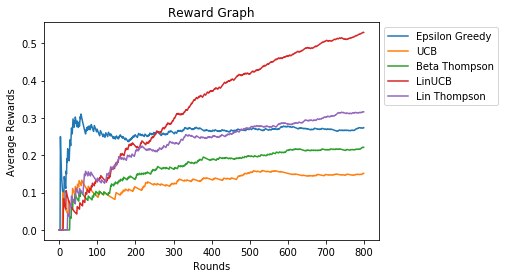

In [17]:
#Run offlineEvaluate function on each method
results_EpsGreedy = offlineEvaluate(EpsGreedy(10, 0.05), arms, rewards, contexts, 800) 

results_UCB = offlineEvaluate(UCB(10, 1.0), arms, rewards, contexts, 800) 

results_BetaThompson = offlineEvaluate(BetaThompson(10, 1.0, 1.0), arms, rewards, contexts, 800) 

results_LinUCB = offlineEvaluate(LinUCB(10, 10, 1.0), arms, rewards, contexts, 800)

results_LinThompson = offlineEvaluate(LinThompson(10, 10, 1.0), arms, rewards, contexts, 800)

# List of reward for each MAB algorithm
reward_Eps_Greedy=list()
reward_ucb=list()
reward_betathompson=list()
reward_LinUCB=list()
reward_LinThompson=list()

#Loop for 800 rounds
#The reason that I use range(1,801) is because when calculate mean
#if i start at zero it will gives an error
for i in range(1,801):
    reward_Eps_Greedy.append(sum(results_EpsGreedy[:i-1])/i)
    reward_ucb.append(sum(results_UCB[:i-1])/i)
    reward_betathompson.append(sum(results_BetaThompson[:i-1])/i)
    reward_LinUCB.append(sum(results_LinUCB[:i-1])/i)
    reward_LinThompson.append(sum(results_LinThompson[:i-1])/i)

#Plot the graph
plt.xlabel('Rounds')
plt.ylabel('Average Rewards')
plt.title("Reward Graph")
plt.plot(reward_Eps_Greedy ,label = "Epsilon Greedy")
plt.plot(reward_ucb ,label = "UCB")
plt.plot(reward_betathompson,label="Beta Thompson")
plt.plot(reward_LinUCB,label="LinUCB")
plt.plot(reward_LinThompson,label="Lin Thompson")
plt.legend(loc="best",bbox_to_anchor=(1,1))
plt.show()

### 6.B.

In [18]:
#Set max result of each alpha and v to -1
max_result_alpha=-1
max_result_v=-1

#Initial value of alpha and v set to zero
alpha=0.0
v=0.0 

#List of alpha value and reward of each alpha value
list_alpha=list()
reward_alpha=list()

#List of v value and reward of each alpha v
list_v=list()
reward_v=list()

#Loop until both alpha and v is greater than 1.0
while(True):  
    if(alpha>1.0 and v>1.0):
        break
    results_LinUCB = offlineEvaluate(LinUCB(10, 10, alpha), arms, rewards, contexts, 800)
    #Check for maximum value then save it
    if max_result_alpha < np.mean(results_LinUCB):
        max_result_alpha=np.mean(results_LinUCB)
        optimal_alpha=alpha
    #Check for maximum value then save it
    results_LinThompson = offlineEvaluate(LinThompson(10, 10, v), arms, rewards, contexts, 800)
    if max_result_v < np.mean(results_LinThompson):
        max_result_v=np.mean(results_LinThompson)
        optimal_v=v
    #Append both alpha and reward to the list
    list_alpha.append(alpha)
    reward_alpha.append(np.mean(results_LinUCB))
    list_v.append(v)
    reward_v.append(np.mean(results_LinThompson))
    #Increment alpha and v value by 0.01
    alpha+=0.01
    v+=0.01

The maximum reward that can be achieve by LinUCB is 0.73125 with alpha value of 0.02
The maximum reward that can be achieve by LinThompson is 0.4475 with v value of 0.06


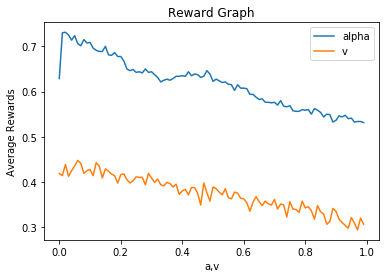

In [23]:
print("The maximum reward that can be achieve by LinUCB is {} with alpha value of {:.2f}".format(max(reward_alpha),optimal_alpha))
print("The maximum reward that can be achieve by LinThompson is {} with v value of {:.2f}".format(max(reward_v),optimal_v))


plt.xlabel("a,v")
plt.ylabel("Average Rewards")
plt.title("Reward Graph")
plt.plot(list_alpha,reward_alpha,label = "alpha")
plt.plot(list_v,reward_v,label = "v")
plt.legend(loc="best",bbox_to_anchor=(1,1))
plt.show()

In [3]:
alpha_range = np.logspace(-3, 3, num=16)

In [4]:
alpha_range

array([1.00000000e-03, 2.51188643e-03, 6.30957344e-03, 1.58489319e-02,
       3.98107171e-02, 1.00000000e-01, 2.51188643e-01, 6.30957344e-01,
       1.58489319e+00, 3.98107171e+00, 1.00000000e+01, 2.51188643e+01,
       6.30957344e+01, 1.58489319e+02, 3.98107171e+02, 1.00000000e+03])